In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    average_precision_score, roc_auc_score
)
import ast

# Current directory
%cd '/content/drive/MyDrive/Capstone Project'

/content/drive/MyDrive/Capstone Project


# Handling invalids

In [ ]:
# Following Varun's code
test_ohe = pd.read_csv('/content/drive/MyDrive/Capstone Project/code/preprocessed_data/test_tree.csv')
test_ohe = test_ohe[~test_ohe["Approved_Flag"].isna()]
test_ohe_100 = test_ohe.sample(n=100, random_state=42).round(4)
true_labels = test_ohe_100["Approved_Flag"].tolist()

# Functions to handle invalids - are used later during the processing of the dataframes-:
def update_invalid(lst1,lst2):
    for i in range(len(lst2)):
        if lst2[i] == 'invalid':
            lst2[i] = float(~int(lst1[i]) & 1)
    return lst2

def calculate_new_auc(x):
    y_pred = ast.literal_eval(x)
    cnt_preds = len(y_pred)
    true_labels_new = true_labels[:cnt_preds]
    y_pred_new = update_invalid(true_labels_new,y_pred)
    roc_auc = roc_auc_score(true_labels_new, y_pred_new)
    return roc_auc

def calculate_new_prauc(x):
    y_pred = ast.literal_eval(x)
    cnt_preds = len(y_pred)
    true_labels_new = true_labels[:cnt_preds]
    y_pred_new = update_invalid(true_labels_new,y_pred)
    pr_auc = average_precision_score(true_labels_new, y_pred_new)
    return pr_auc

def calculate_new_f1(x):
    y_pred = ast.literal_eval(x)
    cnt_preds = len(y_pred)
    true_labels_new = true_labels[:cnt_preds]
    y_pred_new = update_invalid(true_labels_new,y_pred)
    f1 = f1_score(true_labels_new, y_pred_new, zero_division=1)
    return f1

def calculate_new_precision(x):
    y_pred = ast.literal_eval(x)
    cnt_preds = len(y_pred)
    true_labels_new = true_labels[:cnt_preds]
    y_pred_new = update_invalid(true_labels_new,y_pred)
    precision = precision_score(true_labels_new, y_pred_new, zero_division=1)
    return precision

def calculate_new_recall(x):
    y_pred = ast.literal_eval(x)
    cnt_preds = len(y_pred)
    true_labels_new = true_labels[:cnt_preds]
    y_pred_new = update_invalid(true_labels_new,y_pred)
    recall = recall_score(true_labels_new, y_pred_new, zero_division=1)
    return recall

def generate_new_metrics(df):
    df["new_AUCROC"] = df['Prediction'].apply(lambda x: calculate_new_auc(x))
    df["new_PRAUC"] = df['Prediction'].apply(lambda x: calculate_new_prauc(x))
    df["new_F1 Score"] = df['Prediction'].apply(lambda x: calculate_new_f1(x))
    df["new_Precision"] = df['Prediction'].apply(lambda x: calculate_new_precision(x))
    df["new_Recall"] = df['Prediction'].apply(lambda x: calculate_new_recall(x))

# Read csv files, cleaning and put together

In [ ]:
# List of patterns to match multiple groups of files
file_patterns = [
    './Indian_bank_data_results/experiments_result_t_table_7B-GTL-unquant_*.csv',  # Pattern for 7B unquant -t_table- files
    './Indian_bank_data_results/experiments_result_t_table_7B-GTL-8bit_*.csv',  # Pattern for 7B 8bit -t_table- files
    './Indian_bank_data_results/experiments_result_t_table_13B-GTL-8bit_*.csv',  # Pattern for 13B 8bit -t_table- files
    './Indian_bank_data_results/experiments_result_t_table_gpt4omini_*.csv',  # Pattern for GPT4 -t_table- files
    './Indian_bank_data_results/experiments_result_t_annony_7B-GTL-unquant_*.csv',  # Pattern for 7B unquant -t_annony- files
    './Indian_bank_data_results/experiments_result_t_annony_7B-GTL-8bit_*.csv',  # Pattern for 7B 8bit -t_annony- files
    './Indian_bank_data_results/experiments_result_t_annony_13B-GTL-8bit_*.csv',  # Pattern for 13B 8bit -t_annony- files
    './Indian_bank_data_results/experiments_result_t_annony_gpt4omini_*.csv'  # Pattern for GPT4 -t_annony- files
]

# Initialize an empty list to store DataFrames
dfs = []

# Loop over each pattern and get all matching file names
for pattern in file_patterns:
    file_names = glob.glob(pattern)  # Get files matching the pattern

    # Check the model (7B-unquant, 7B-8bit, 13B-8bit or GPT-4) of the current pattern (we'll use it to add a column with the model)
    if '7B-GTL-unquant' in pattern:
        model = '7B-GTL-unquant'
    elif '7B-GTL-8bit' in pattern:
        model = '7B-GTL-8bit'
    elif '13B-GTL-8bit' in pattern:
        model = '13B-GTL-8bit'
    elif 'gpt4omini' in pattern:
        model = 'GPT4'
    else:
        model = 'unknown'  # Default case if none of the conditions match (serves as check)

    # Check if the current pattern belongs to t_table or t_annony (we'll use it to add a column indicating if it corresponds to t_table or t_annony)
    if 't_table' in pattern:
        prompt_type = 't_table'
    elif 't_annony' in pattern:
        prompt_type = 't_annony'
    else:
        prompt_type = 'unknown' # Default case if none of the conditions match (serves as check)

    # Read each file and append the DataFrame to the list
    for file in file_names:
        df = pd.read_csv(file)

        # Add the 'model' column to the DataFrame
        df['Model'] = model

        # Add the 'prompt_type' column to the DataFrame
        df['Prompt Type'] = prompt_type

        # Handle special cases:

        # Case 1: Check if the second column (instead of the first one) is called "Num Features"
        # This happens in experiments_result_t_table_7B-GTL-8bit_48 and experiments_result_t_table_7B-GTL-8bit_64 csv files
        if df.columns[1] == "Num Features" and df.columns[0] == "Unnamed: 0":
          # Drop the first column (index 0) ... it is a column with an index
          df = df.drop(df.columns[0], axis=1)

        # Case 2: If both "F1 Score" and "F1_Score" columns are present, drop the "F1_Score" column
        # This happens in some csv files, eg the 13B ones
        if "F1 Score" in df.columns and "F1_Score" in df.columns:
            df = df.drop("F1_Score", axis=1)

        # If only "F1_Score" column is present, rename to "F1 Score"
        if "F1_Score" in df.columns:
            df = df.rename(columns={'F1_Score': 'F1 Score'})

        # Case 3: If both "Num Features" and "feature_set_size" columns are present, drop the "feature_set_size" column
        # This happens in some csv files, eg experiments_result_t_annony_7B-GTL_128_10
        if "Num Features" in df.columns and "feature_set_size" in df.columns:
            df = df.drop("feature_set_size", axis=1)

        # Case 4: Match the AUC columns names between the different csv files
        # This happens in some files, eg: experiments_result_t_annony_7B-GTL-8bit_8 or experiments_result_t_annony_7B-GTL-8bit_0
        if "PR-AUC" in df.columns:
          df = df.rename(columns={'PR-AUC': 'PR_AUC'})
        if "ROC-AUC" in df.columns:
          df = df.rename(columns={'ROC-AUC': 'ROC_AUC'})
        if "AUCROC" in df.columns:
          df = df.rename(columns={'AUCROC': 'ROC_AUC'})

        # Case 5: Drop rows where 'Num Features' column has NaN values
        # This happens in the file 'experiments_result_t_table_7B-GTL_32' that contains empty rows
        df = df.dropna(subset=['Num Features'])

        # Case 6: Filter out rows where 'Sample Size' is equal to 48
        df = df[df['Sample Size'] != 48]

        # Case 7: Filter out rows where 'Sample Size' is equal to 128 (because many invalids for some experiments)
        df = df[df['Sample Size'] != 128]


        ### Handling invalids: new columns
        df["new_AUCROC"] = df['Prediction'].apply(lambda x: calculate_new_auc(x))
        df["new_PRAUC"] = df['Prediction'].apply(lambda x: calculate_new_prauc(x))
        df["new_F1 Score"] = df['Prediction'].apply(lambda x: calculate_new_f1(x))
        df["new_Precision"] = df['Prediction'].apply(lambda x: calculate_new_precision(x))
        df["new_Recall"] = df['Prediction'].apply(lambda x: calculate_new_recall(x))

        # Reorder columns to make 'model' and 'prompt_type' the first two columns
        columns = ['Model', 'Prompt Type'] + [col for col in df.columns if col not in ['Model', 'Prompt Type']]
        df = df[columns]

        dfs.append(df)

# Concatenate all DataFrames into a single DataFrame
results = pd.concat(dfs, ignore_index=True)

# Drop some columns that appear on just a few dataframes: Unnamed: 0 & invalid_prop
#results = results.drop("Unnamed: 0", axis=1)
results = results.drop("invalid_prop", axis=1)

<ipython-input-4-cc9666d12b03>:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat(dfs, ignore_index=True)


In [ ]:
results.head()

,Model,Prompt Type,Num Features,Sample Size,Class 1 Proportion,Set ID,Run Number,Accuracy,Precision,Recall,F1 Score,Prediction,new_AUCROC,new_PRAUC,new_F1 Score,new_Precision,new_Recall,PR_AUC,ROC_AUC
0,7B-GTL-unquant,t_table,5.0,32.0,0.1,Set_1_Prop_0.1,1.0,0.86,0.0,0.0,0.000000,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.494253,0.130000,0.000000,0.000,0.000000,NaN,NaN
1,7B-GTL-unquant,t_table,5.0,32.0,0.1,Set_2_Prop_0.1,1.0,0.87,0.0,0.0,0.000000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.500000,0.130000,0.000000,1.000,0.000000,NaN,NaN
2,7B-GTL-unquant,t_table,5.0,32.0,0.1,Set_3_Prop_0.1,1.0,0.84,0.0,0.0,0.000000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.482759,0.130000,0.000000,0.000,0.000000,NaN,NaN
3,7B-GTL-unquant,t_table,5.0,32.0,0.1,Set_4_Prop_0.1,1.0,0.81,0.125,0.076923,0.095238,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, ...",0.498232,0.129615,0.095238,0.125,0.076923,NaN,NaN
4,7B-GTL-unquant,t_table,5.0,32.0,0.1,Set_5_Prop_0.1,1.0,0.83,0.0,0.0,0.000000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.477011,0.130000,0.000000,0.000,0.000000,NaN,NaN


# Some checks

In [ ]:
# To check we have aggregated all the csv files

# Path to the subfolder containing the CSV files
folder_path = '/content/drive/MyDrive/Capstone Project/Indian_bank_data_results/experiments_result*.csv'

# Use glob to get a list of all CSV files in the subfolder
csv_files = glob.glob(folder_path)

# Total number of CSV files
print(f"Total CSV files in the Indian_bank_data_results folder: {len(csv_files)}")

print('')

# Total number of csv included on the dataset results
print(f"Total CSV files aggregated: {len(dfs)}")

assert len(csv_files) == len(dfs)

Total CSV files in the Indian_bank_data_results folder: 47

Total CSV files aggregated: 47


In [ ]:
# Additional checks:
print('Additional checks:...\n')

## Model
print('Unique values results for Model')
print(results['Model'].unique())

print('')

## Prompt Type
print('Unique values results for Prompt Type')
print(results['Prompt Type'].unique())

print('')

## Num Features
print('Unique values results for Num Features')
print(results['Num Features'].unique())

print('')

## Sample Size
print('Unique values results for Sample Size')
print(results['Sample Size'].unique())

print('')

## F1 Score
# Check if all elements in 'F1 Score' are numeric
print('Are all elements of "F1 Score" numeric?')
print(pd.to_numeric(results['F1 Score'], errors='coerce').notna().all())

print('')

## PR_AUC
print('Are all elements of "PR_AUC" numeric?')
print(pd.to_numeric(results['PR_AUC'], errors='coerce').notna().all())

# Which are the non-numeric values?
# Convert column to numeric, non-numeric values become NaN
results['PR_AUC_is_numeric'] = pd.to_numeric(results['PR_AUC'], errors='coerce')
# Identify rows where the value is NaN (non-numeric)
print(f"Non_numeric_values = {results[results['PR_AUC_is_numeric'].isna()]['PR_AUC'].unique()}")
results = results.drop("PR_AUC_is_numeric", axis=1)

print('')

## ROC_AUC
print('Are all elements of "ROC_AUC" numeric?')
print(pd.to_numeric(results['ROC_AUC'], errors='coerce').notna().all())

# Which are the non-numeric values?
# Convert column to numeric, non-numeric values become NaN
results['ROC_AUC_is_numeric'] = pd.to_numeric(results['ROC_AUC'], errors='coerce')
# Identify rows where the value is NaN (non-numeric)
print(f"Non_numeric_values = {results[results['ROC_AUC_is_numeric'].isna()]['ROC_AUC'].unique()}")
results = results.drop("ROC_AUC_is_numeric", axis=1)

print('')
print('---------------')

print('The new columns do not suffer from this problem:')
print('Are all elements of "new_F1 Score" numeric?')
print(pd.to_numeric(results['new_F1 Score'], errors='coerce').notna().all())

print('')

print('Are all elements of "new_PRAUC" numeric?')
print(pd.to_numeric(results['new_PRAUC'], errors='coerce').notna().all())

print('')

print('Are all elements of "new_AUCROC" numeric?')
print(pd.to_numeric(results['new_AUCROC'], errors='coerce').notna().all())

Additional checks:...

Unique values results for Model
['7B-GTL-unquant' '7B-GTL-8bit' '13B-GTL-8bit' 'GPT4']

Unique values results for Prompt Type
['t_table' 't_annony']

Unique values results for Num Features
[ 5. 10. 20. 30. 40.]

Unique values results for Sample Size
[32. 64.  8. 16.  0.]

Are all elements of "F1 Score" numeric?
True

Are all elements of "PR_AUC" numeric?
False
Non_numeric_values = [nan 'invalid']

Are all elements of "ROC_AUC" numeric?
False
Non_numeric_values = [nan 'invalid']

---------------
The new columns do not suffer from this problem:
Are all elements of "new_F1 Score" numeric?
True

Are all elements of "new_PRAUC" numeric?
True

Are all elements of "new_AUCROC" numeric?
True


In [ ]:
# Once showed the invalid problem is solved, we rename the columns as initially
results = results.drop("F1 Score", axis=1)
results = results.drop("Recall", axis=1)
results = results.drop("Precision", axis=1)
results = results.drop("PR_AUC", axis=1)
results = results.drop("ROC_AUC", axis=1)
results = results.rename(columns={'new_Precision': 'Precision', 'new_Recall': 'Recall','new_F1 Score': 'F1 Score', 'new_PRAUC':'PR_AUC', 'new_AUCROC':'ROC_AUC'})

# Define the new order of columns
new_column_order = ['Model', 'Prompt Type', 'Num Features', 'Sample Size', 'Class 1 Proportion', 'Set ID', 'Run Number', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Prediction', 'PR_AUC', 'ROC_AUC']

# Reorder columns
results = results[new_column_order]

In [ ]:
results.head()

,Model,Prompt Type,Num Features,Sample Size,Class 1 Proportion,Set ID,Run Number,Accuracy,Precision,Recall,F1 Score,Prediction,PR_AUC,ROC_AUC
0,7B-GTL-unquant,t_table,5.0,32.0,0.1,Set_1_Prop_0.1,1.0,0.86,0.000,0.000000,0.000000,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.130000,0.494253
1,7B-GTL-unquant,t_table,5.0,32.0,0.1,Set_2_Prop_0.1,1.0,0.87,1.000,0.000000,0.000000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.130000,0.500000
2,7B-GTL-unquant,t_table,5.0,32.0,0.1,Set_3_Prop_0.1,1.0,0.84,0.000,0.000000,0.000000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.130000,0.482759
3,7B-GTL-unquant,t_table,5.0,32.0,0.1,Set_4_Prop_0.1,1.0,0.81,0.125,0.076923,0.095238,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, ...",0.129615,0.498232
4,7B-GTL-unquant,t_table,5.0,32.0,0.1,Set_5_Prop_0.1,1.0,0.83,0.000,0.000000,0.000000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.130000,0.477011


In [ ]:
results.to_csv('aggregated_table_2024_12_03_1150am.csv', index=False)

# Plots Model Performance

Two functions: plot_model_performance1 and plot_model_performance2

plot_model_performance1: x-axis: number of features

plot_model_performance2: x-axis: sample size

In [ ]:
# Function to plot model performance

# Model Performance 1 (x-axis: number of features)
def plot_model_performance1(results, model, prompt_type, aggregation='median', plot_shaded_regions=False):
    """
    Function to filter rows based on model and prompt type,
    then plot the ROC AUC and F1 Score with shaded regions (optional).
    You can choose whether to plot mean or median using the aggregation parameter.

    Parameters:
    results (pd.DataFrame): The DataFrame containing the model performance data.
    model (str): The model name to filter the data.
    prompt_type (str): The prompt type to filter the data.
    aggregation (str): Aggregation method for plotting ('mean' or 'median').
    plot_shaded_regions (bool): Whether to include shaded regions representing ±1 std deviation.
    """

    # Step 1: Filter the results DataFrame based on model and prompt type
    filtered_results = results[(results['Model'] == model) & (results['Prompt Type'] == prompt_type)].copy()

    # Step 2: Calculate the chosen aggregation (mean or median) across runs for each combination of parameters
    if aggregation == 'mean':
        agg_func = 'mean'
    elif aggregation == 'median':
        agg_func = 'median'
    else:
        raise ValueError("aggregation must be either 'mean' or 'median'")

    results_summary = filtered_results.groupby(['Num Features', 'Sample Size', 'Class 1 Proportion']).agg(
        ROC_AUC_agg=('ROC_AUC', agg_func),
        ROC_AUC_std=('ROC_AUC', 'std'),
        F1_Score_agg=('F1 Score', agg_func),
        F1_Score_std=('F1 Score', 'std')
    ).reset_index()

    # Step 3: Set the color palette
    palette = sns.color_palette("magma_r", len(results_summary['Sample Size'].unique()))

    # Step 4: Plot F1 Score with or without shaded regions
    g = sns.FacetGrid(results_summary, col='Class 1 Proportion', hue='Sample Size', height=4, aspect=1.5, palette=palette)
    g.map(sns.lineplot, 'Num Features', 'F1_Score_agg', marker="o", errorbar=None).add_legend()

    for ax, class_proportion in zip(g.axes.flat, results_summary['Class 1 Proportion'].unique()):
        subset = results_summary[results_summary['Class 1 Proportion'] == class_proportion]
        for idx, sample_size in enumerate(subset['Sample Size'].unique()):
            subset_sample = subset[subset['Sample Size'] == sample_size]
            color = palette[idx]

            # Add shaded regions if plot_shaded_regions is True
            if plot_shaded_regions:
                ax.fill_between(
                    subset_sample['Num Features'],
                    subset_sample['F1_Score_agg'] - subset_sample['F1_Score_std'],
                    subset_sample['F1_Score_agg'] + subset_sample['F1_Score_std'],
                    color=color,
                    alpha=0.3
                )

    # Adjust plot labels and title
    g.set_axis_labels("Num Features", "F1 Score")
    g.set_titles("Class 1 Proportion: {col_name}")
    plt.suptitle(f"{aggregation.capitalize()} F1 Score by Num Features and Sample Size", y=1.05)

    # Show the plot
    plt.show()

    # Step 5: Optionally, plot ROC AUC with shaded regions (if plot_shaded_regions is True)
    # You can uncomment and modify this section for ROC AUC plotting similarly
    # g = sns.FacetGrid(results_summary, col='Class 1 Proportion', hue='Sample Size', height=4, aspect=1.5, palette=palette)
    # g.map(sns.lineplot, 'Num Features', 'ROC_AUC_agg', marker="o", errorbar=None).add_legend()

    # for ax, class_proportion in zip(g.axes.flat, results_summary['Class 1 Proportion'].unique()):
    #     subset = results_summary[results_summary['Class 1 Proportion'] == class_proportion]
    #     for idx, sample_size in enumerate(subset['Sample Size'].unique()):
    #         subset_sample = subset[subset['Sample Size'] == sample_size]
    #         color = palette[idx]
    #         if plot_shaded_regions:
    #             ax.fill_between(
    #                 subset_sample['Num Features'],
    #                 subset_sample['ROC_AUC_agg'] - subset_sample['ROC_AUC_std'],
    #                 subset_sample['ROC_AUC_agg'] + subset_sample['ROC_AUC_std'],
    #                 color=color,
    #                 alpha=0.3
    #             )
    # g.set_axis_labels("Num Features", "ROC AUC")
    # g.set_titles("Class 1 Proportion: {col_name}")
    # plt.suptitle(f"{aggregation.capitalize()} ROC AUC by Num Features and Sample Size", y=1.05)
    # plt.show()


In [ ]:
# Model Performance 2 (x-axis: sample size, each line represents a different number of features)
def plot_model_performance2(results, model, prompt_type, aggregation='median', plot_shaded_regions=False):
    """
    Function to filter rows based on model and prompt type,
    then plot the ROC AUC and F1 Score with shaded regions (optional).
    You can choose whether to plot mean or median using the aggregation parameter.

    Parameters:
    results (pd.DataFrame): The DataFrame containing the model performance data.
    model (str): The model name to filter the data.
    prompt_type (str): The prompt type to filter the data.
    aggregation (str): Aggregation method for plotting ('mean' or 'median').
    plot_shaded_regions (bool): Whether to include shaded regions representing ±1 std deviation.
    """

    # Step 1: Filter the results DataFrame based on model and prompt type
    filtered_results = results[(results['Model'] == model) & (results['Prompt Type'] == prompt_type)].copy()

    # Step 2: Calculate the chosen aggregation (mean or median) across runs for each combination of parameters
    if aggregation == 'mean':
        agg_func = 'mean'
    elif aggregation == 'median':
        agg_func = 'median'
    else:
        raise ValueError("aggregation must be either 'mean' or 'median'")

    results_summary = filtered_results.groupby(['Num Features', 'Sample Size', 'Class 1 Proportion']).agg(
        ROC_AUC_agg=('ROC_AUC', agg_func),
        ROC_AUC_std=('ROC_AUC', 'std'),
        F1_Score_agg=('F1 Score', agg_func),
        F1_Score_std=('F1 Score', 'std')
    ).reset_index()

    # Step 3: Set the color palette
    palette = sns.color_palette("magma_r", len(results_summary['Num Features'].unique()))

    # Step 4: Plot F1 Score with or without shaded regions
    g = sns.FacetGrid(results_summary, col='Class 1 Proportion', hue='Num Features', height=4, aspect=1.5, palette=palette)
    g.map(sns.lineplot, 'Sample Size', 'F1_Score_agg', marker="o", errorbar=None).add_legend()

    for ax, class_proportion in zip(g.axes.flat, results_summary['Class 1 Proportion'].unique()):
        subset = results_summary[results_summary['Class 1 Proportion'] == class_proportion]
        for idx, num_features in enumerate(subset['Num Features'].unique()):
            subset_sample = subset[subset['Num Features'] == num_features]
            color = palette[idx]

            # Add shaded regions if plot_shaded_regions is True
            if plot_shaded_regions:
                ax.fill_between(
                    subset_sample['Sample Size'],
                    subset_sample['F1_Score_agg'] - subset_sample['F1_Score_std'],
                    subset_sample['F1_Score_agg'] + subset_sample['F1_Score_std'],
                    color=color,
                    alpha=0.3
                )

    # Adjust plot labels and title
    g.set_axis_labels("Sample Size", "F1 Score")
    g.set_titles("Class 1 Proportion: {col_name}")
    plt.suptitle(f"{aggregation.capitalize()} F1 Score by Sample Size and Num Features", y=1.05)

    # Show the plot
    plt.show()

    # Step 5: Optionally, plot ROC AUC with shaded regions (if plot_shaded_regions is True)
    # You can uncomment and modify this section for ROC AUC plotting similarly
    # g = sns.FacetGrid(results_summary, col='Class 1 Proportion', hue='Num Features', height=4, aspect=1.5, palette=palette)
    # g.map(sns.lineplot, 'Sample Size', 'ROC_AUC_agg', marker="o", errorbar=None).add_legend()

    # for ax, class_proportion in zip(g.axes.flat, results_summary['Class 1 Proportion'].unique()):
    #     subset = results_summary[results_summary['Class 1 Proportion'] == class_proportion]
    #     for idx, num_features in enumerate(subset['Num Features'].unique()):
    #         subset_sample = subset[subset['Num Features'] == num_features]
    #         color = palette[idx]
    #         if plot_shaded_regions:
    #             ax.fill_between(
    #                 subset_sample['Sample Size'],
    #                 subset_sample['ROC_AUC_agg'] - subset_sample['ROC_AUC_std'],
    #                 subset_sample['ROC_AUC_agg'] + subset_sample['ROC_AUC_std'],
    #                 color=color,
    #                 alpha=0.3
    #             )
    # g.set_axis_labels("Sample Size", "ROC AUC")
    # g.set_titles("Class 1 Proportion: {col_name}")
    # plt.suptitle(f"{aggregation.capitalize()} ROC AUC by Sample Size and Num Features", y=1.05)
    # plt.show()


**T Table**

Model: 7B-GTL-unquant | Prompt Type: t_table


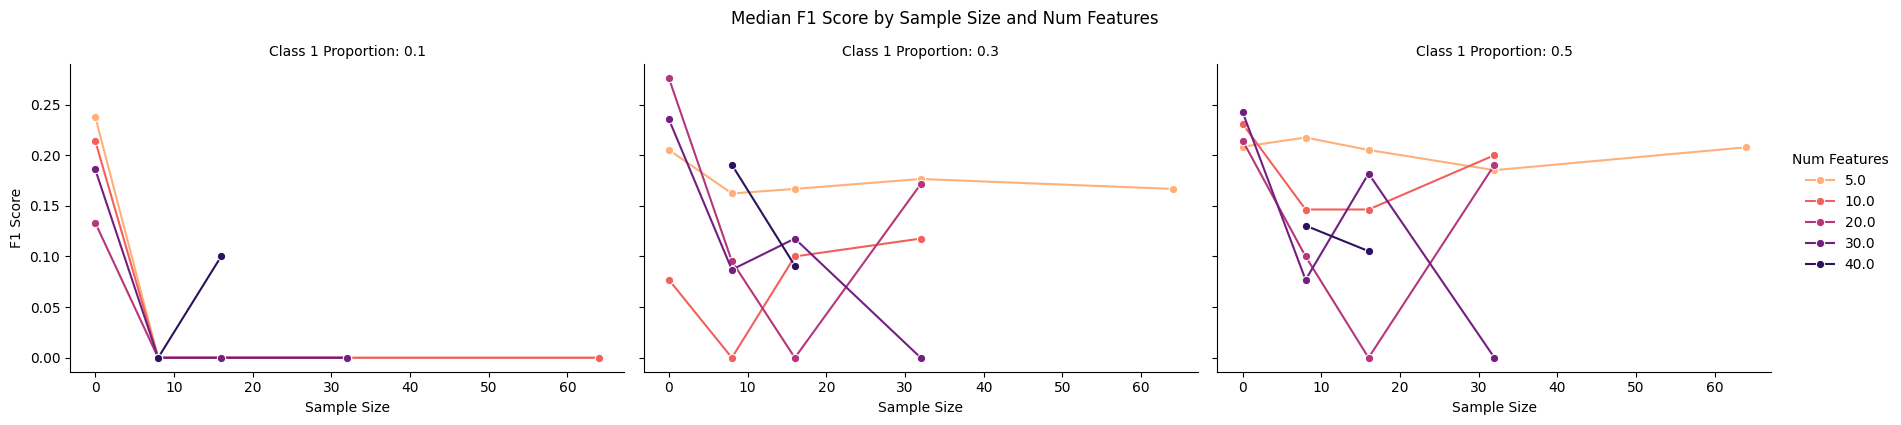

In [ ]:
# 7B-unquant T-table
# Model Performance

model = "7B-GTL-unquant"
prompt_type = "t_table"

print(f"Model: {model} | Prompt Type: {prompt_type}")

plot_model_performance2(results, model, prompt_type)

Model: 7B-GTL-8bit | Prompt Type: t_table


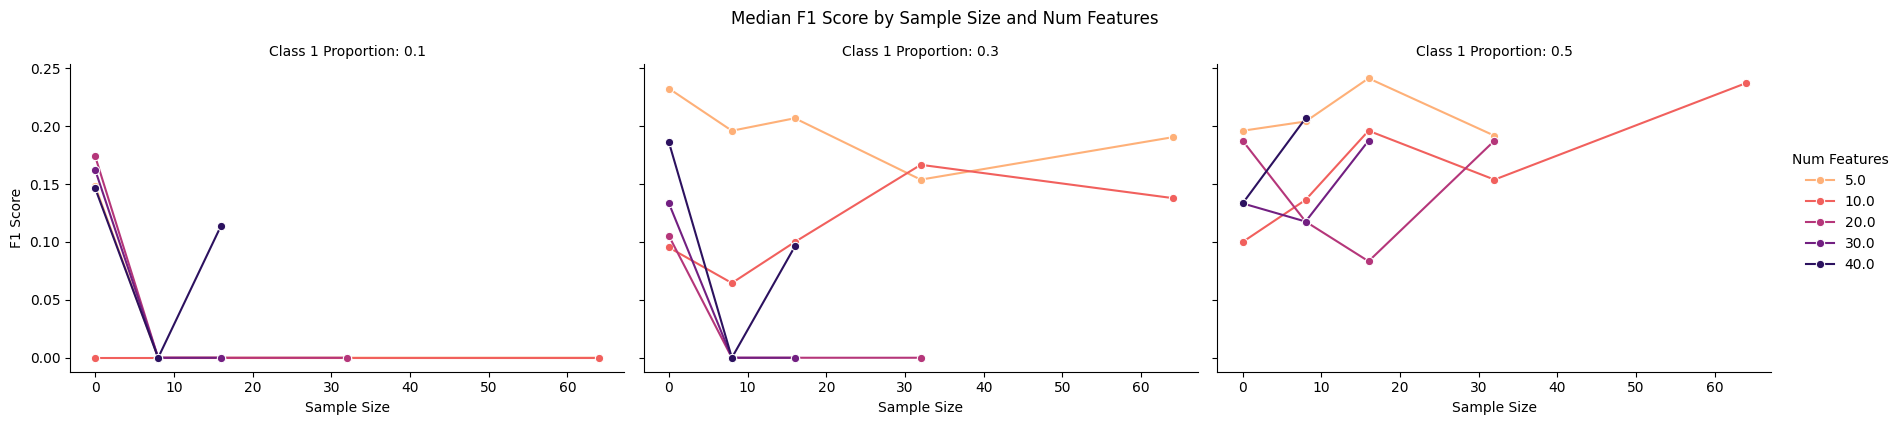

In [ ]:
# 7B-8bit T-table
# Model Performance

model = "7B-GTL-8bit"
prompt_type = "t_table"

print(f"Model: {model} | Prompt Type: {prompt_type}")

plot_model_performance2(results, model, prompt_type)

Model: 13B-GTL-8bit | Prompt Type: t_table


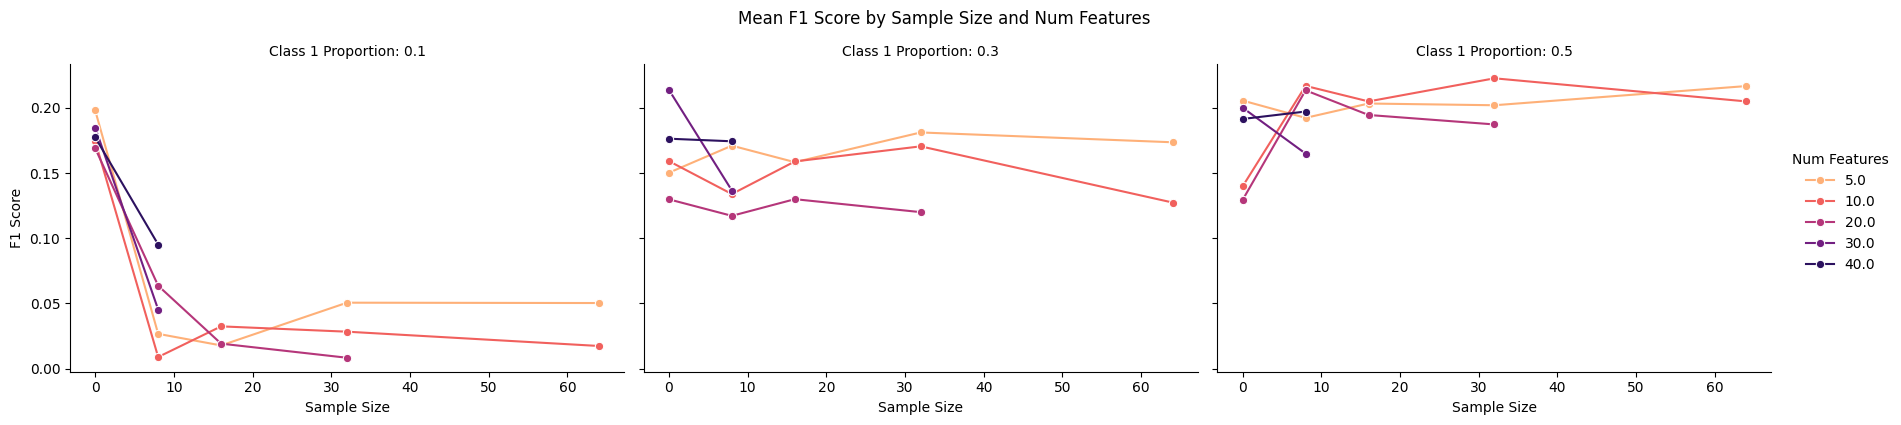

In [ ]:
# 13B-8bit T-table
# Model Performance

model = "13B-GTL-8bit"
prompt_type = "t_table"

print(f"Model: {model} | Prompt Type: {prompt_type}")

plot_model_performance2(results, model, prompt_type)

Model: GPT4 | Prompt Type: t_table


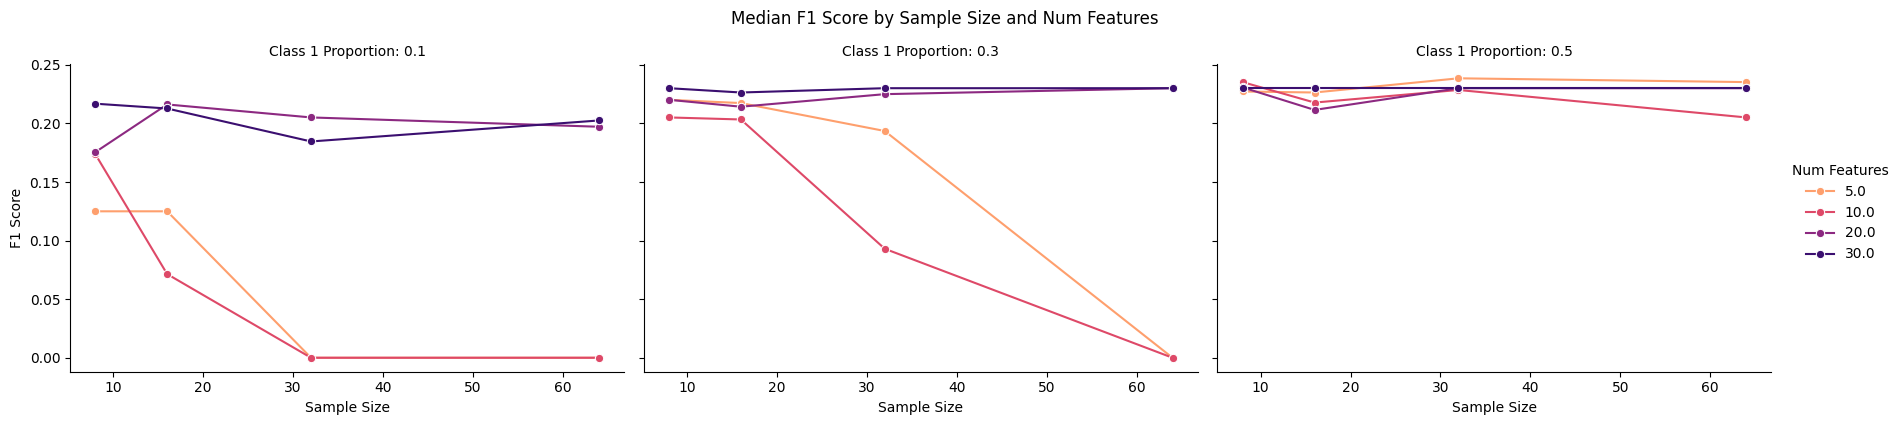

In [ ]:
# GPT4 T-table
# Model Performance

model = "GPT4"
prompt_type = "t_table"

print(f"Model: {model} | Prompt Type: {prompt_type}")

plot_model_performance2(results, model, prompt_type)

**T annony**

Model: 7B-GTL-unquant | Prompt Type: t_annony


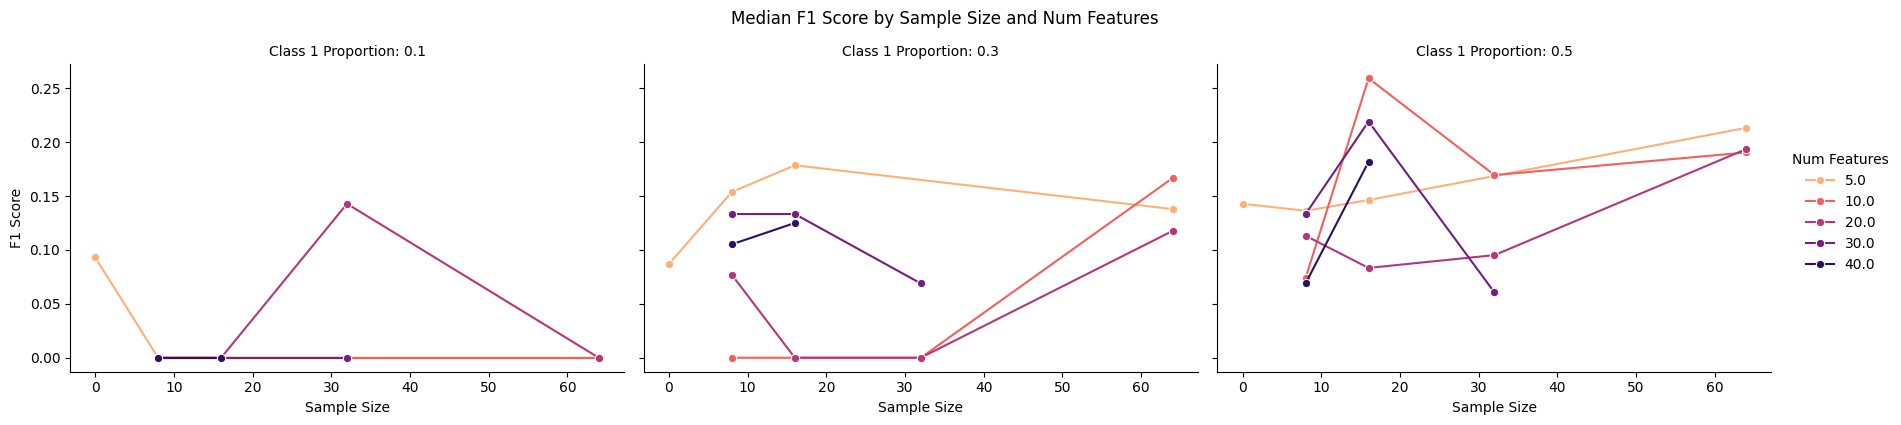

In [ ]:
# 7B-unquant T-annony
# Model Performance

model = "7B-GTL-unquant"
prompt_type = "t_annony"

print(f"Model: {model} | Prompt Type: {prompt_type}")

plot_model_performance2(results, model, prompt_type)

Model: 7B-GTL-8bit | Prompt Type: t_annony


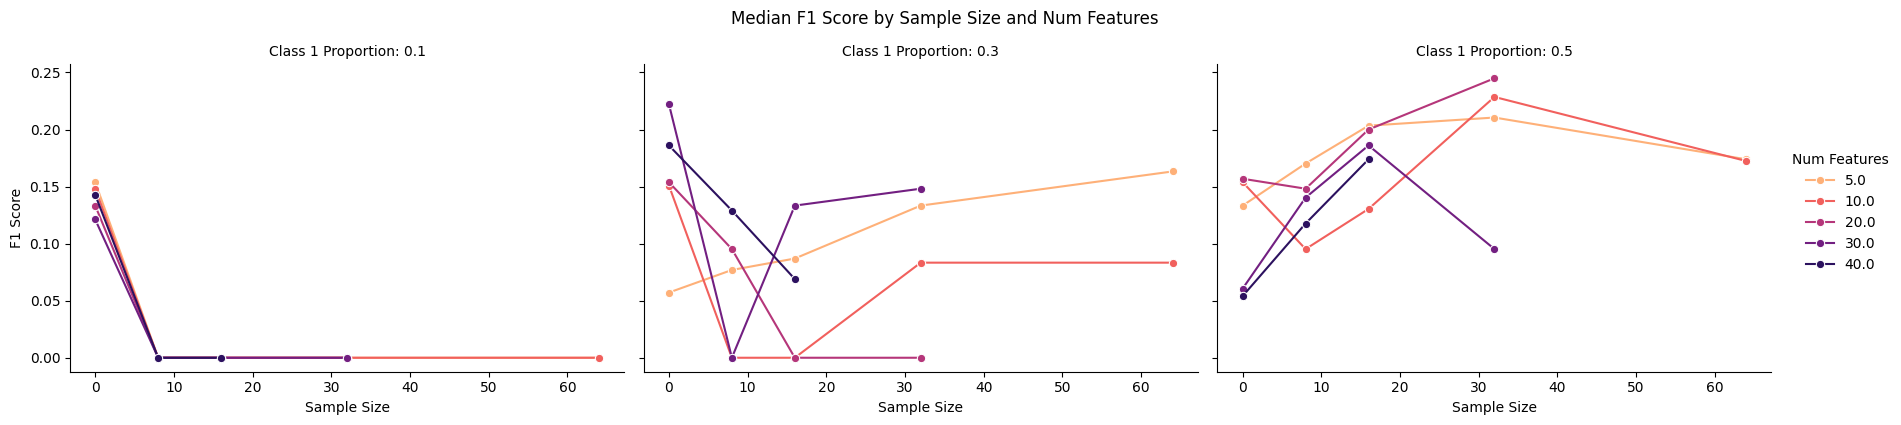

In [ ]:
# 7B-8bit T-annony
# Model Performance

model = "7B-GTL-8bit"
prompt_type = "t_annony"

print(f"Model: {model} | Prompt Type: {prompt_type}")

plot_model_performance2(results, model, prompt_type)

Model: 13B-GTL-8bit | Prompt Type: t_annony


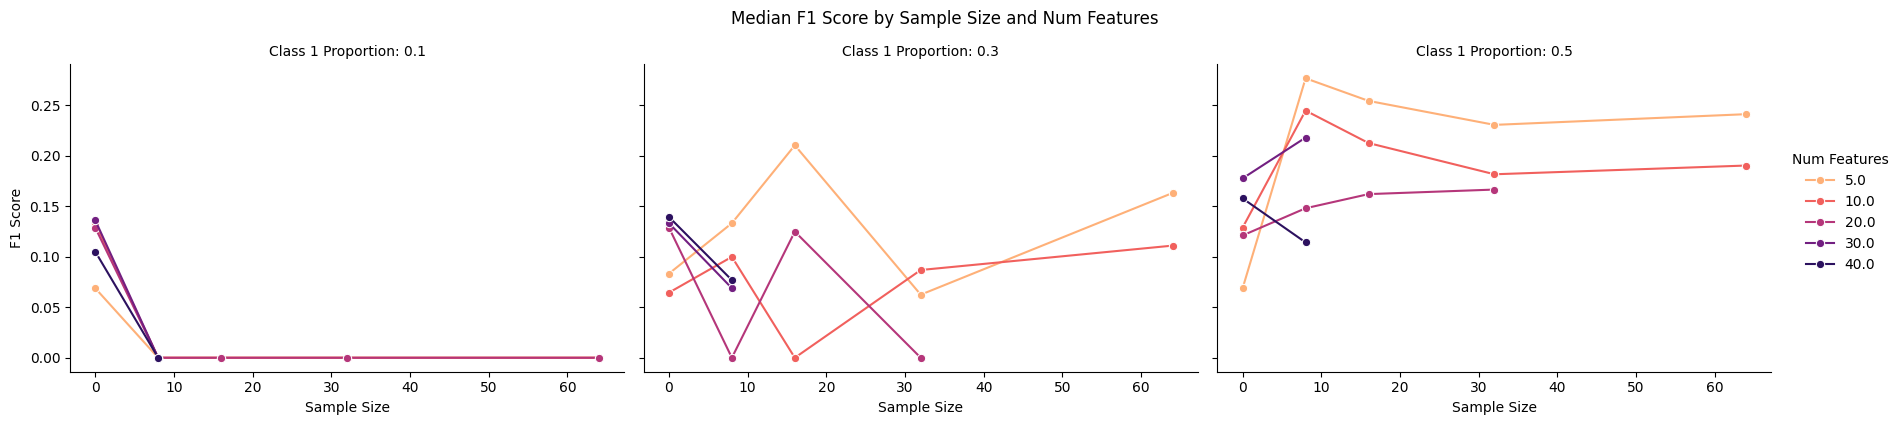

In [ ]:
# 13B-8bit T-annony
# Model Performance

model = "13B-GTL-8bit"
prompt_type = "t_annony"

print(f"Model: {model} | Prompt Type: {prompt_type}")

plot_model_performance2(results, model, prompt_type)

Model: GPT4 | Prompt Type: t_annony


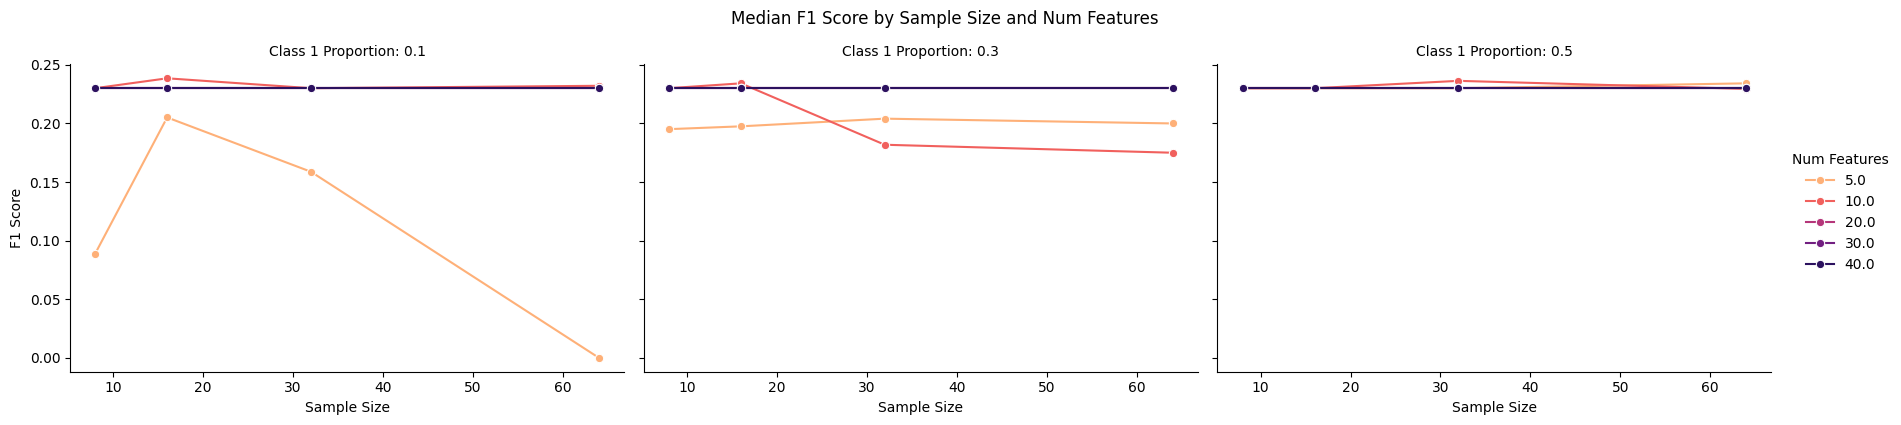

In [ ]:
# GPT4 T-annony
# Model Performance

model = "GPT4"
prompt_type = "t_annony"

print(f"Model: {model} | Prompt Type: {prompt_type}")

plot_model_performance2(results, model, prompt_type)

# Summary table

In [ ]:
# Grouping by Model, Prompt Type, and Sample Size, then calculating the mean for F1 Score and ROC_AUC
# Replace 'Invalid' values with NaN for ROC_AUC
results['ROC_AUC'] = pd.to_numeric(results['ROC_AUC'], errors='coerce')

results_summary = results.groupby(['Model', 'Prompt Type', 'Sample Size']).agg(
    F1_Score_mean=('F1 Score', 'mean'),
    ROC_AUC_mean=('ROC_AUC', 'mean')
).reset_index()

# Pivoting the results to create the desired table format
f1_table = results_summary.pivot_table(index=['Prompt Type', 'Model'],
                                       columns='Sample Size',
                                       values='F1_Score_mean',
                                       aggfunc='mean')

roc_auc_table = results_summary.pivot_table(index=['Prompt Type', 'Model'],
                                            columns='Sample Size',
                                            values='ROC_AUC_mean',
                                            aggfunc='mean')

# Displaying the tables
print("F1 Score Means:")
print(f1_table)
print("\nROC AUC Means:")
print(roc_auc_table)

F1 Score Means:
Sample Size                     0.0       8.0       16.0      32.0      64.0
Prompt Type Model                                                           
t_annony    13B-GTL-8bit    0.119103  0.092935  0.110993  0.097328  0.112854
            7B-GTL-8bit     0.130229  0.072619  0.083966  0.097300  0.100534
            7B-GTL-unquant  0.111618  0.068523  0.101922  0.078351  0.110749
            GPT4                 NaN  0.216957  0.224096  0.221100  0.212759
t_table     13B-GTL-8bit    0.173315  0.130500  0.124377  0.130099  0.131732
            7B-GTL-8bit     0.145590  0.084342  0.098623  0.114485  0.142783
            7B-GTL-unquant  0.201892  0.095752  0.094629  0.108355  0.123731
            GPT4                 NaN  0.202212  0.194154  0.178120  0.154475

ROC AUC Means:
Sample Size                     0.0       8.0       16.0      32.0      64.0
Prompt Type Model                                                           
t_annony    13B-GTL-8bit    0.347541  0.5034